### LSTM Networks on hourly data ###
Now we will test LSTM networks on the hourly data. We moved over to google Google colab to use a GPU for faster training time. Similar to what we dested with Dense NN, we will build 3 different LSTM networks for predicting 24 hours out, 12, hours out, and 1 hour out. 

In [1]:
# load libraries
import pandas as pd
import numpy as np
from datetime import datetime
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from matplotlib import style
style.use('fivethirtyeight')

In [2]:
# Load historical bitcoin dataset
path = 'drive/MyDrive/Colab Notebooks/DL_Project/kaggle/input/'
file_name = 'bitstampUSD_1-min_data_2012-01-01_to_2020-12-31.csv'
full_path = path + file_name
bitcoinData = pd.read_csv(full_path)

bitcoinData.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# renaming columns of dataset
bitcoinData = bitcoinData.rename(columns = {
    'Volume_(BTC)':'VolumeBTC',
    'Volume_(Currency)':'VolumeCurrency',
    'Weighted_Price':'WeightedPrice'
})

# convert Timestamp to a date
bitcoinData['Timestamp'] = pd.to_datetime( bitcoinData['Timestamp'], unit = 's' )

# remove rows with null values from the dataframe
bitcoinData = bitcoinData.dropna(how='all', subset=['Open','High','Low','Close','WeightedPrice'])
print('Dataframe rows after dropping null values:', bitcoinData.shape[0])# no remaining null values in any column for any row
bitcoinData.isnull().any()

Dataframe rows after dropping null values: 3484305


Timestamp         False
Open              False
High              False
Low               False
Close             False
VolumeBTC         False
VolumeCurrency    False
WeightedPrice     False
dtype: bool

In [4]:
# Function to get the label every row by the hour, i.e. it drops the minute and seconds from Timestamp
def getHour(dt):
    s = str(dt.year) + '-' + str(dt.month) + '-' + str(dt.day) + ' ' + str(dt.hour)
    return datetime.strptime(s, '%Y-%m-%d %H')

bitcoinData['Hour'] = bitcoinData['Timestamp'].apply(getHour)

#Calculate hourly open and close prices
hourOpen = pd.DataFrame(bitcoinData.groupby(['Hour'])['Timestamp'].min())
hourClose = pd.DataFrame(bitcoinData.groupby(['Hour'])['Timestamp'].max())
hourOpen = pd.merge(hourOpen, bitcoinData[['Hour','Timestamp','Open']], how='left', on=['Hour','Timestamp']).drop(['Timestamp'], axis=1)
hourClose = pd.merge(hourClose, bitcoinData[['Hour','Timestamp','Open']], how='left', on=['Hour','Timestamp']).drop(['Timestamp'], axis=1)

# Merge hourly open and close prices into hourlyData DataFrame 
hourlyData = pd.merge(hourOpen, hourClose, how='inner', on=['Hour'])
hourlyData = hourlyData.rename(columns={'Open_x':'Open', 'Open_y':'Close'})

# set the 'Hour' column as the index
hourlyData = hourlyData.set_index('Hour')

# define function to calculate hourly average price weighted by volume
def hourlyWeightAvg(hourGroup, volCol, wPriceCol):
    vol = hourGroup[volCol]
    price = hourGroup[wPriceCol]
    
    return ((vol * price).sum())/(vol.sum())

# find the high and low price for each hour
hourlyData['High'] = bitcoinData.groupby(['Hour'])['High'].max()
hourlyData['Low'] = bitcoinData.groupby(['Hour'])['Low'].min()

# The volume for an hour is the sum of trade volume for each minute in the hour
hourlyData['VolumeBTC'] = bitcoinData.groupby(['Hour'])['VolumeBTC'].sum()
hourlyData['VolumeCurrency'] = bitcoinData.groupby(['Hour'])['VolumeCurrency'].sum()

# Calculate the weighted average for each hour
hourlyData['WeightedHourAvg'] = bitcoinData.groupby(['Hour']).apply(hourlyWeightAvg, 'VolumeBTC', 'WeightedPrice')
hourlyData = hourlyData.reset_index()

hourlyData.tail(10)

,Hour,Open,Close,High,Low,VolumeBTC,VolumeCurrency,WeightedHourAvg
75364,2020-12-30 15:00:00,28193.92,28144.00,28290.00,28025.37,316.952464,8.922800e+06,28151.855925
75365,2020-12-30 16:00:00,28160.90,28111.00,28232.10,27896.34,457.983947,1.286516e+07,28090.842790
75366,2020-12-30 17:00:00,28150.92,28246.33,28328.68,28050.00,422.149256,1.190804e+07,28208.132527
75367,2020-12-30 18:00:00,28259.01,28509.71,28534.08,28246.00,595.872076,1.692029e+07,28395.848192
75368,2020-12-30 19:00:00,28523.16,28798.65,28917.39,28465.73,1213.070914,3.487729e+07,28751.241026
75369,2020-12-30 20:00:00,28807.89,28834.83,29010.32,28605.54,758.997803,2.186878e+07,28812.704316
75370,2020-12-30 21:00:00,28789.77,28897.27,29008.00,28510.00,474.773822,1.367532e+07,28803.855291
75371,2020-12-30 22:00:00,28896.96,28760.94,28942.32,28602.61,237.251362,6.832905e+06,28800.276645
75372,2020-12-30 23:00:00,28731.27,28910.54,28936.93,28643.32,142.471053,4.105594e+06,28817.041394
75373,2020-12-31 00:00:00,28893.21,28893.21,28928.49,28893.21,5.757679,1.664497e+05,28909.166061


In [5]:
# define a scaler to scale the date
normalizer = MinMaxScaler(feature_range=(0,1))

# scale the data
scaledData= normalizer.fit_transform(hourlyData[
    ['Open','High','Low','Close','VolumeBTC','WeightedHourAvg',]].values)

#LSTM Network predicting 24 hours out #

In [6]:
# Create test and validation sets
# Here the test and validation sets use 24-hour steps. So although the data is 
# broken into hours the models here will still be predicting daily prices. The input blocks are
# 72 hours long. The validation set is the last year of the historical data running from January 1, 2020 
# until December 31, 2020

X=[]
Y=[]

for i in range(24,len(scaledData)-24, 24):
        X.append(np.array(scaledData[i-23:i+1]))
        Y.append(scaledData[i+24,1])
        
testSize = 365

Xlstm_train = np.array(X[:len(X)-testSize])
Xlstm_test = np.array(X[len(X)-testSize:])
Ylstm_train = np.array(Y[:len(Y)-testSize])
Ylstm_test = np.array(Y[len(Y)-testSize:])

assert (len(Xlstm_train)==len(Ylstm_train))
assert (len(Xlstm_test)==len(Ylstm_test))

timesteps = Xlstm_train.shape[1]
features = Xlstm_train.shape[2]


# Create a Recurrent NN using LSTM layers to make predictions 24 hours out
dropoutRate=0.3

recurrentNN = keras.Sequential()

recurrentNN.add(keras.layers.LSTM(units=1024, return_sequences=True, input_shape=(timesteps, features)))
recurrentNN.add(keras.layers.Dropout(dropoutRate))
recurrentNN.add(keras.layers.LSTM(units=1024, return_sequences=True))
recurrentNN.add(keras.layers.Dropout(dropoutRate))
recurrentNN.add(keras.layers.LSTM(units=512, return_sequences=True))
recurrentNN.add(keras.layers.Dropout(dropoutRate))
recurrentNN.add(keras.layers.LSTM(units=256, return_sequences=True))
recurrentNN.add(keras.layers.Dropout(dropoutRate))
recurrentNN.add(keras.layers.LSTM(units=128, return_sequences=True))
recurrentNN.add(keras.layers.Dropout(dropoutRate))
recurrentNN.add(keras.layers.LSTM(units=64, return_sequences=False))
recurrentNN.add(keras.layers.Dropout(dropoutRate))
recurrentNN.add(keras.layers.Dense(units=128, activation='relu'))
recurrentNN.add(keras.layers.Dropout(dropoutRate))
recurrentNN.add(keras.layers.Dense(units=1))              

recurrentNN.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
saveModelRecurrent = keras.callbacks.ModelCheckpoint(filepath ='drive/MyDrive/Colab Notebooks/DL_Project/HourLSTM1', monitor='val_loss', mode='min', save_best_only=True)
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20)

# train the model
recurrentNN.fit(Xlstm_train, Ylstm_train, epochs=200, validation_data=(Xlstm_test, Ylstm_test), 
                callbacks=[saveModelRecurrent, earlyStopping])

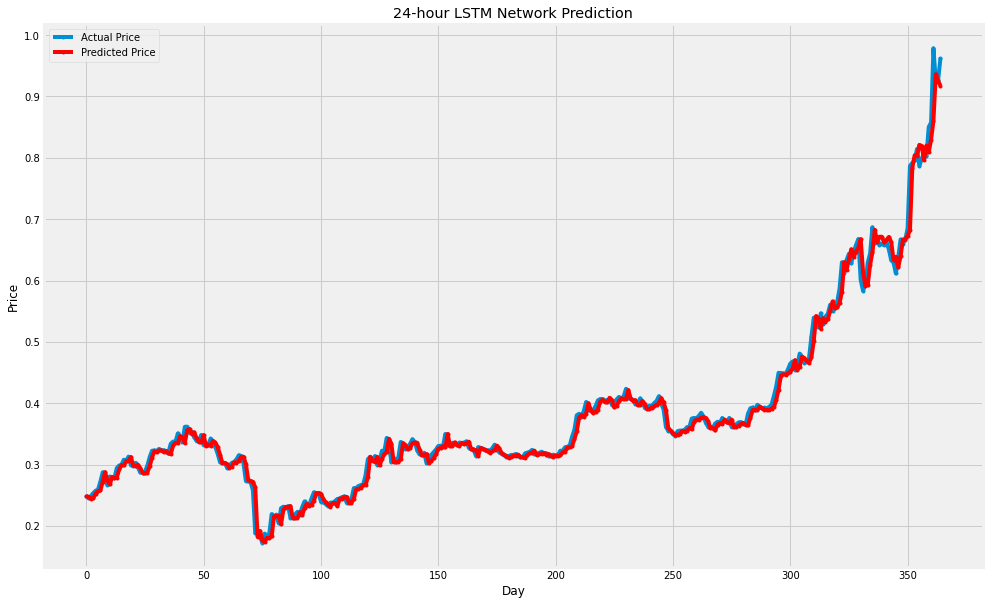

In [7]:
# Load best model
lstmModel = keras.models.load_model('drive/MyDrive/Colab Notebooks/DL_Project/HourLSTM1')

# Have the model predict on the validation set
predsLSTM = lstmModel.predict(Xlstm_test)
predsLSTM = [x[0] for x in predsLSTM]

# plot the results
plt.figure(figsize=(15,10))
plt.title('24-hour LSTM Network Prediction')
plt.xlabel('Day')
plt.ylabel('Price')
plt.plot(Ylstm_test, marker='.', label="Actual Price")
plt.plot(predsLSTM, 'r', marker='.', label="Predicted Price")

plt.legend()

In [8]:
# Function the simulates a buy and hold strategy
def naiveTrader2(money, prices):
    shares = money/prices[0]
    return shares*prices[-1]

# Function that simulates a trading strategy based on the model prediction
def allegedlySmartTrader2(money, prices, predictedPrices):
    assert len(prices) == len(predictedPrices)
    
    for i in range(len(prices)-1):
        if predictedPrices[i+1] > predictedPrices[i]:
            money = (money/prices[i])*prices[i+1]

    return money

In [9]:
# Simulate trading strategies
buyAndHold = naiveTrader2(100, Ylstm_test)
tradeOnModel = allegedlySmartTrader2(100, Ylstm_test, predsLSTM)

print('Buy and Hold Strategy: %.2f'%(buyAndHold))
print('Trading Strategy Based on Model: %.2f'%(tradeOnModel))   

Buy and Hold Strategy: 387.50
Trading Strategy Based on Model: 365.03


# LSTM Network predicting 12 hours out #

In [11]:
# Create training and validation sets for a model that will make predicitons every 12 hours,
# i.e. the model goes through the data in 12-hour steps (but looking at 24 hour chunks of data)
# and makes predictions 12 hours out.
X=[]
Y=[]

for i in range(24,len(scaledData)-24, 12):
        X.append(np.array(scaledData[i-23:i+1]))
        Y.append(scaledData[i+12,1])
        
testSize = 365

Xlstm_train = np.array(X[:len(X)-testSize])
Xlstm_test = np.array(X[len(X)-testSize:])
Ylstm_train = np.array(Y[:len(Y)-testSize])
Ylstm_test = np.array(Y[len(Y)-testSize:])

assert (len(Xlstm_train)==len(Ylstm_train))
assert (len(Xlstm_test)==len(Ylstm_test))


In [ ]:

saveModelRecurrent = keras.callbacks.ModelCheckpoint(filepath ='drive/MyDrive/Colab Notebooks/DL_Project/HourLSTM2', monitor='val_loss', mode='min', save_best_only=True)
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20)


recurrentNN.fit(Xlstm_train, Ylstm_train, epochs=200, validation_data=(Xlstm_test, Ylstm_test), 
                callbacks=[saveModelRecurrent, earlyStopping])

Epoch 1/200
185/185 [==============================] - 6s 35ms/step - loss: 3.8586e-04 - val_loss: 2.4262e-04


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/DL_Project/HourLSTM2/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/DL_Project/HourLSTM2/assets


Epoch 2/200
185/185 [==============================] - 6s 35ms/step - loss: 3.7741e-04 - val_loss: 2.2258e-04


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/DL_Project/HourLSTM2/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/DL_Project/HourLSTM2/assets


Epoch 3/200
185/185 [==============================] - 6s 35ms/step - loss: 4.1421e-04 - val_loss: 0.0037
Epoch 4/200
185/185 [==============================] - 7s 35ms/step - loss: 3.6936e-04 - val_loss: 0.0022
Epoch 5/200
185/185 [==============================] - 7s 35ms/step - loss: 4.0583e-04 - val_loss: 0.0050
Epoch 6/200
185/185 [==============================] - 6s 35ms/step - loss: 3.3332e-04 - val_loss: 0.0053
Epoch 7/200
185/185 [==============================] - 7s 35ms/step - loss: 3.5514e-04 - val_loss: 2.5880e-04
Epoch 8/200
185/185 [==============================] - 6s 35ms/step - loss: 3.7786e-04 - val_loss: 0.0013
Epoch 9/200
185/185 [==============================] - 6s 35ms/step - loss: 3.7124e-04 - val_loss: 0.0037
Epoch 10/200
185/185 [==============================] - 6s 35ms/step - loss: 3.6543e-04 - val_loss: 0.0023
Epoch 11/200
185/185 [==============================] - 6s 35ms/step - loss: 3.8677e-04 - val_loss: 0.0013
Epoch 12/200
185/185 [==================

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/DL_Project/HourLSTM2/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/DL_Project/HourLSTM2/assets


Epoch 16/200
185/185 [==============================] - 6s 35ms/step - loss: 3.6155e-04 - val_loss: 0.0021
Epoch 17/200
185/185 [==============================] - 6s 35ms/step - loss: 3.0248e-04 - val_loss: 0.0026
Epoch 18/200
185/185 [==============================] - 6s 35ms/step - loss: 3.4919e-04 - val_loss: 2.1835e-04
Epoch 19/200
185/185 [==============================] - 6s 35ms/step - loss: 3.8752e-04 - val_loss: 0.0017
Epoch 20/200
185/185 [==============================] - 6s 35ms/step - loss: 3.6984e-04 - val_loss: 9.6285e-04
Epoch 21/200
185/185 [==============================] - 6s 35ms/step - loss: 3.5947e-04 - val_loss: 0.0040
Epoch 22/200
185/185 [==============================] - 6s 35ms/step - loss: 3.4528e-04 - val_loss: 5.5883e-04
Epoch 23/200
185/185 [==============================] - 6s 35ms/step - loss: 3.5019e-04 - val_loss: 0.0026
Epoch 24/200
185/185 [==============================] - 6s 35ms/step - loss: 3.4472e-04 - val_loss: 6.9808e-04
Epoch 25/200
185/185 

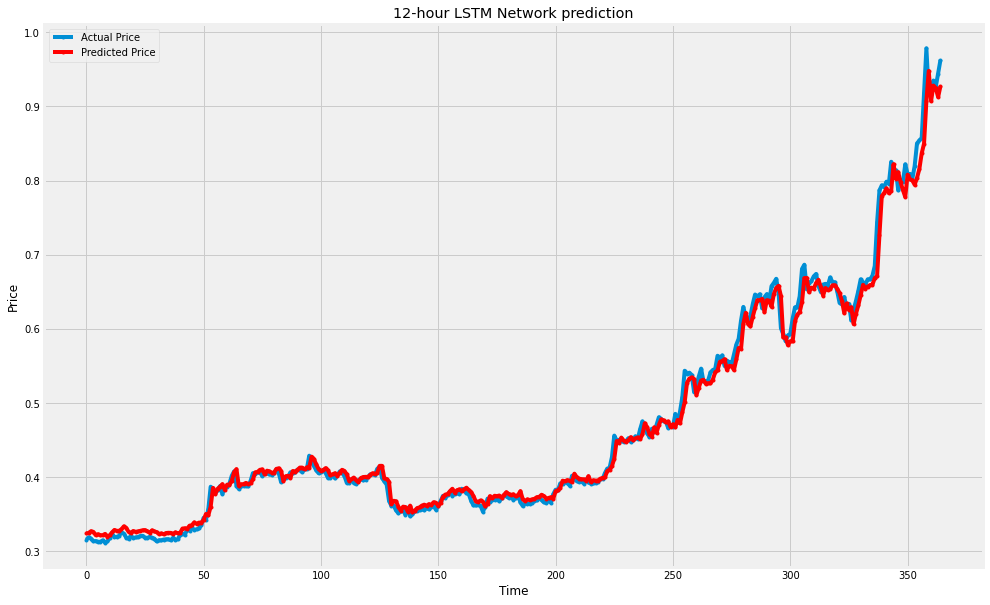

In [12]:
# Load best model
lstmModel = keras.models.load_model('drive/MyDrive/Colab Notebooks/DL_Project/HourLSTM2')

# have model predict on validation set
predsLSTM = lstmModel.predict(Xlstm_test)
predsLSTM = [x[0] for x in predsLSTM]

#plot results
plt.figure(figsize=(15,10))
plt.title('12-hour LSTM Network prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.plot(Ylstm_test, marker='.', label="Actual Price")
plt.plot(predsLSTM, 'r', marker='.', label="Predicted Price")
plt.legend()

In [13]:
# Simulate trading strategies
buyAndHold = naiveTrader2(100, Ylstm_test)
tradeOnModel = allegedlySmartTrader2(100, Ylstm_test, predsLSTM)

print('Buy and Hold Strategy: %.2f'%(buyAndHold))
print('Trading Strategy Based on Model: %.2f'%(tradeOnModel))  

Buy and Hold Strategy: 304.84
Trading Strategy Based on Model: 222.38


# LSTM Network predicting 1 hour out #

In [14]:
# Create training and validation sets for model that will go through the data in 24 hour steps and 
# make price predictions 1 hour out. 

X=[]
Y=[]

for i in range(24,len(scaledData)-24, 3):
        X.append(np.array(scaledData[i-23:i+1]))
        Y.append(scaledData[i+1,1])
        
testSize = 2920

Xlstm_train = np.array(X[12000:len(X)-testSize])
Xlstm_test = np.array(X[len(X)-testSize:])
Ylstm_train = np.array(Y[12000:len(Y)-testSize])
Ylstm_test = np.array(Y[len(Y)-testSize:])

assert (len(Xlstm_train)==len(Ylstm_train))
assert (len(Xlstm_test)==len(Ylstm_test))
len(Xlstm_test)

2920

In [ ]:
saveModelRecurrent = keras.callbacks.ModelCheckpoint(filepath ='drive/MyDrive/Colab Notebooks/DL_Project/HourLSTM3', monitor='val_loss', mode='min', save_best_only=True)
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20)

# train model
recurrentNN.fit(Xlstm_train, Ylstm_train, epochs=200, validation_data=(Xlstm_test, Ylstm_test), 
                callbacks=[saveModelRecurrent, earlyStopping])

Epoch 1/200
319/319 [==============================] - 12s 38ms/step - loss: 3.5132e-04 - val_loss: 9.0643e-04


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/DL_Project/HourLSTM3/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/DL_Project/HourLSTM3/assets


Epoch 2/200
319/319 [==============================] - 12s 38ms/step - loss: 2.9783e-04 - val_loss: 3.8014e-04


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/DL_Project/HourLSTM3/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/DL_Project/HourLSTM3/assets


Epoch 3/200
319/319 [==============================] - 12s 38ms/step - loss: 2.8540e-04 - val_loss: 2.5170e-04


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/DL_Project/HourLSTM3/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/DL_Project/HourLSTM3/assets


Epoch 4/200
319/319 [==============================] - 12s 38ms/step - loss: 3.0576e-04 - val_loss: 5.7419e-04
Epoch 5/200
319/319 [==============================] - 12s 37ms/step - loss: 2.8660e-04 - val_loss: 8.5374e-04
Epoch 6/200
319/319 [==============================] - 12s 37ms/step - loss: 2.9516e-04 - val_loss: 4.1917e-04
Epoch 7/200
319/319 [==============================] - 12s 37ms/step - loss: 2.9695e-04 - val_loss: 0.0013
Epoch 8/200
319/319 [==============================] - 12s 37ms/step - loss: 2.7719e-04 - val_loss: 0.0011
Epoch 9/200
319/319 [==============================] - 12s 37ms/step - loss: 2.7383e-04 - val_loss: 7.8689e-04
Epoch 10/200
319/319 [==============================] - 12s 38ms/step - loss: 2.8588e-04 - val_loss: 7.9705e-04
Epoch 11/200
319/319 [==============================] - 12s 37ms/step - loss: 2.7383e-04 - val_loss: 0.0012
Epoch 12/200
319/319 [==============================] - 12s 37ms/step - loss: 2.7647e-04 - val_loss: 0.0016
Epoch 13/200
3

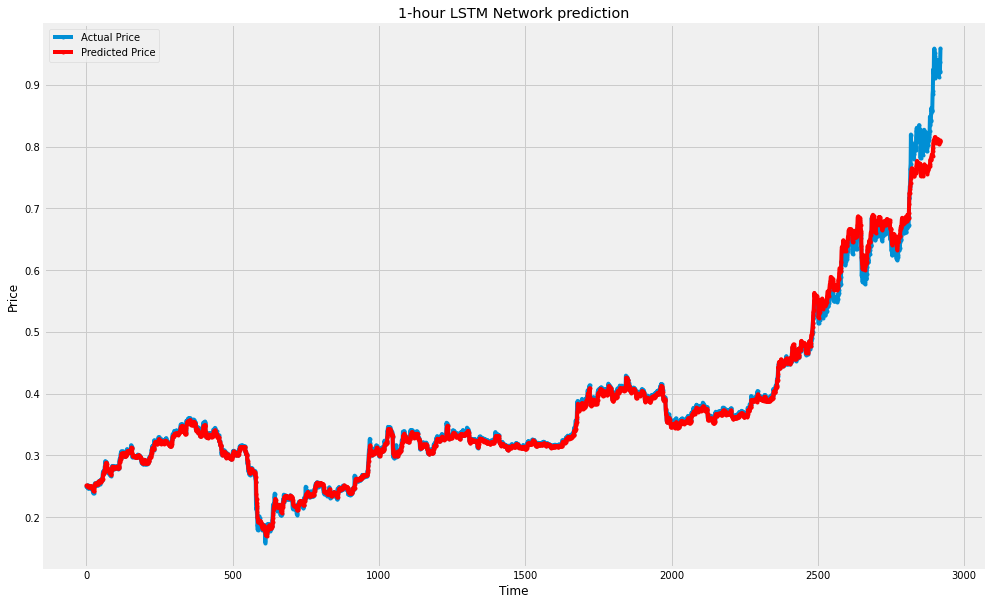

In [16]:
#load the best Model
lstmModel = keras.models.load_model('drive/MyDrive/Colab Notebooks/DL_Project/HourLSTM3')

# Have model predict on validation set
predsLSTM = lstmModel.predict(Xlstm_test)
predsLSTM = [x[0] for x in predsLSTM]

# Plot the results
plt.figure(figsize=(15,10))
plt.title('1-hour LSTM Network prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.plot(Ylstm_test, marker='.', label="Actual Price")
plt.plot(predsLSTM, 'r', marker='.', label="Predicted Price")
plt.legend()

In [17]:
#simulate trading strategies
buyAndHold  = naiveTrader2(100, Ylstm_test)
tradeOnModel = allegedlySmartTrader2(100, Ylstm_test, predsLSTM)

print('Buy and Hold Strategy: %.2f'%(buyAndHold))
print('Trading Strategy Based on Model: %.2f'%(tradeOnModel))

Buy and Hold Strategy: 382.97
Trading Strategy Based on Model: 24284.05
